# Import Libraries

In [1]:
import pandas as pd
import sidetable
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from ChannelAttribution import heuristic_models,markov_model

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Version: 2.1.7


# Define Functions

In [2]:
def df_check(df):
    """
    Perform a comprehensive check of a DataFrame, returning key statistics for each column:
    size, data type, non-null count, unique values, null count, and null percentage.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - pandas DataFrame with the following statistics for each column:
        - column: Name of the column
        - dtypes: Data type of the column
        - count: Number of non-null entries
        - nunique: Number of unique values
        - sum_null: Number of null (missing) values
        - null_ratio: Percentage of missing values
    """
    # Print the shape of the dataframe
    print(f'shape: {df.shape}')
    
    # Calculate the 'dtypes','count','nunique','sum_null','null_ratio' for each column. 
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        n_count = df[col].count()
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,n_count,nunique,sum_null,round(sum_null/(n_count+sum_null)*100,1)])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','count','nunique','sum_null','null_ratio']
    return df_check 


def describe_metrics(df, columns, group_by):
    """
    Generate summary statistics for the specified columns in the DataFrame.
    It uses pandas' `describe()` function, formatted for improved readability and clarity.
    
    Parameters:
    - df: pandas DataFrame
    - columns: List of column names to summarize
    - group_by: Column to group by (default is 'tot_conv')
    
    Returns:
    - pandas DataFrame with summary statistics
    """
    results = []

    for column in columns:
        # Get describe for the metric, keep the group_by column as a regular column
        desc = df.reset_index().groupby([group_by])[column].describe().reset_index()
        desc['Metric'] = column  # Add a 'Metric' column to identify the column name
        results.append(desc)

    # Concatenate all results together and set the index properly
    df_summary = pd.concat(results).set_index(['Metric', group_by]).round(2)

    return df_summary


def style_dataframe(df, columns_and_formats, include_cond_formatting=True):
    """
    This function styles a DataFrame by applying column-specific formatting and
    optionally applying conditional formatting for visual effect.

    Parameters:
    - df (DataFrame): The DataFrame to be styled.
    - columns_and_formats (dict): A dictionary containing the column names as keys
                                   and the corresponding formatting strings as values.
    - include_cond_formatting (bool): Whether to apply background gradient (True) or not (False).

    Returns:
    - A styled DataFrame with applied formatting.
    """
    
    # Apply the conditional formatting (background gradient) if specified
    if include_cond_formatting:
        return (
            df
            .style
            .background_gradient(cmap='Blues')  
            .format(columns_and_formats) 
        )
    else:
        # Just apply the formatting without background gradient
        return (
            df
            .style
            .format(columns_and_formats)  # Apply the formatting rules from the dictionary
        )

# Read Dataset

In [3]:
file_path='C:/Users/MertEygi/Downloads/Personal/senior-data-analyst-technical-assessment-1/Senior Data Analyst - Technical Assessment/data/'
file_name='TBA_attribution_data.csv'

# read the dataset from csv
df_data=pd.read_csv(f"{file_path}{file_name}")
df_data

,cookie,time,interaction,conversion,conversion_value,channel
0,11111FkCnDfDDf1iC97iC713B,2018-07-03T13:02:11Z,impression,0.0,0.0,Instagram
1,11111FkCnDfDDf1iC97iC713B,2018-07-17T19:15:07Z,impression,0.0,0.0,Online Display
2,11111FkCnDfDDf1iC97iC713B,2018-07-24T15:51:46Z,impression,0.0,0.0,Online Display
3,11111FkCnDfDDf1iC97iC713B,2018-07-29T07:44:51Z,impression,0.0,0.0,Online Display
4,1111nACkD9nFkBBDECD3ki11E,2018-07-03T09:44:57Z,impression,0.0,0.0,Paid Search
...,...,...,...,...,...,...
586932,ooooEiB1CCoEf9fiiC91Dfhfk,2018-07-12T23:50:45Z,impression,0.0,0.0,Online Display
586933,ooooEiB1CCoEf9fiiC91Dfhfk,2018-07-12T23:50:54Z,impression,0.0,0.0,Online Display
586934,ooooiBh71D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0.0,0.0,Paid Search
586935,ooooiBh71D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0.0,0.0,Online Video


In [4]:
# Checking the columns 
df_check(df_data)

shape: (586937, 6)


,column,dtypes,count,nunique,sum_null,null_ratio
0,cookie,object,586937,240108,0,0.0
1,time,object,586937,485110,0,0.0
2,interaction,object,586937,2,0,0.0
3,conversion,float64,586928,2,9,0.0
4,conversion_value,float64,586937,12,0,0.0
5,channel,object,586937,5,0,0.0


- We have 240K unique users.
- The 'time' column is in 'object' format, so I will create a 'timestamp' column to preserve the original data.
- We don’t have much missing data, only few records in the 'conversion' column. It can be ignored but I will check quickly.
- The 'interaction' and 'conversion' columns have binary info.

# Data PreProcesssing

In [5]:
# Checking if any duplicate rows in data
df_data[df_data.duplicated(keep='first')]

,cookie,time,interaction,conversion,conversion_value,channel
92,111hCBnCB7oi7ADAEnEBCnBEE,2018-07-16T13:31:54Z,impression,0.0,0.0,Online Video
94,111hCBnCB7oi7ADAEnEBCnBEE,2018-07-16T13:32:19Z,impression,0.0,0.0,Online Video
178,1137ok3iD1h3kkEDCB1nk9iko,2018-07-11T11:54:56Z,impression,0.0,0.0,Online Video
181,1137ok3iD1h3kkEDCB1nk9iko,2018-07-11T11:55:46Z,impression,0.0,0.0,Online Video
184,1137ok3iD1h3kkEDCB1nk9iko,2018-07-11T11:55:49Z,impression,0.0,0.0,Online Video
...,...,...,...,...,...,...
586932,ooooEiB1CCoEf9fiiC91Dfhfk,2018-07-12T23:50:45Z,impression,0.0,0.0,Online Display
586933,ooooEiB1CCoEf9fiiC91Dfhfk,2018-07-12T23:50:54Z,impression,0.0,0.0,Online Display
586934,ooooiBh71D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0.0,0.0,Paid Search
586935,ooooiBh71D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0.0,0.0,Online Video


- 4345 rows are duplicated in the data, so we need to clean it

In [6]:
# Remove all duplicates by keeping their first occurrence
df_data.drop_duplicates(keep = "first",inplace=True)

In [7]:
#Let's check the data after cleaning 
df_check(df_data)

shape: (582592, 6)


,column,dtypes,count,nunique,sum_null,null_ratio
0,cookie,object,582592,240108,0,0.0
1,time,object,582592,485110,0,0.0
2,interaction,object,582592,2,0,0.0
3,conversion,float64,582583,2,9,0.0
4,conversion_value,float64,582592,12,0,0.0
5,channel,object,582592,5,0,0.0


### Creating 'timestamp' and checking missing values

In [8]:
df_data['timestamp'] = pd.to_datetime(df_data['time'], errors='coerce', utc=True)

print(f"Data range: [{df_data['timestamp'].min()}, {df_data['timestamp'].max()}]")

Data range: [2018-07-01 13:13:16+00:00, 2018-07-31 23:59:30+00:00]


- We have a full month of data.

In [9]:
gb_cols=['interaction']
(
    df_data
    .groupby(gb_cols)
    .agg(
        num_unique_user=("cookie","nunique"),
        min_time=("timestamp","min"),
        max_time=("timestamp","max"),
        conversion=("conversion","sum"),
        conversion_value=("conversion_value","sum"),
    )
    .sort_values('min_time')
    .round(2)
)

,num_unique_user,min_time,max_time,conversion,conversion_value
interaction,,,,,
impression,232691,2018-07-01 13:13:16+00:00,2018-07-31 23:59:30+00:00,0.0,0.0
conversion,17639,2018-07-01 13:18:28+00:00,2018-07-31 19:07:21+00:00,17639.0,16723694.5


- We have two interaction types: 'impressions' and 'conversions'. Let's convert its type as 'category'. 
- There are no conversions or conversion values assigned to 'impressions,' as expected.
- The first recorded 'conversion' took place after the 'impression,' as expected.

In [10]:
# Now, check the records having null values
df_data.query("conversion.isna()")

,cookie,time,interaction,conversion,conversion_value,channel,timestamp
74,111f1nF77Afhf9ho7Aiff1Chh,2018-07-14T20:31:43Z,impression,NaN,0.0,Online Video,2018-07-14 20:31:43+00:00
277,113iB9Bk33EA3nfAA9i73niki,2018-07-17T10:42:27Z,impression,NaN,0.0,Facebook,2018-07-17 10:42:27+00:00
469,119AFB9fiFfhEB3nEfDok9hDA,2018-07-23T12:10:09Z,impression,NaN,0.0,Facebook,2018-07-23 12:10:09+00:00
760,11BCC1Co9fk3ni1CC19AE3i3E,2018-07-03T06:25:36Z,impression,NaN,0.0,Facebook,2018-07-03 06:25:36+00:00
1030,11D1CfBfn7o1AEE9k773CnFhA,2018-07-13T13:17:54Z,impression,NaN,0.0,Online Display,2018-07-13 13:17:54+00:00
1218,11EBE19hkFFoihBDonhAFokn7,2018-07-17T22:53:31Z,impression,NaN,0.0,Online Video,2018-07-17 22:53:31+00:00
115814,97oinFDfB31hDCnA9o7hk9B3f,2018-07-30T18:33:06Z,impression,NaN,0.0,Facebook,2018-07-30 18:33:06+00:00
389170,fFnfn9oFh9DhDDkk7kAF9o1B3,2018-07-09T20:11:47Z,impression,NaN,0.0,Instagram,2018-07-09 20:11:47+00:00
444679,i3oBCoEi1nh3hk13ACA393nFh,2018-07-02T08:47:11Z,impression,NaN,0.0,Online Video,2018-07-02 08:47:11+00:00


- There only impressions, so we can fill replace those with 0.

In [11]:
#Fill the null conversions with 0 as all records are belong to 'impressions'
df_data.fillna({'conversion':0}, inplace=True)

#Convert interaction column to 'category' so that 'conversion' has higher priority.
df_data['interaction'] = pd.Categorical(df_data['interaction'], categories=['impression', 'conversion'], ordered=True)

#Cheking the latest dateframe
df_check(df_data)

shape: (582592, 7)


,column,dtypes,count,nunique,sum_null,null_ratio
0,cookie,object,582592,240108,0,0.0
1,time,object,582592,485110,0,0.0
2,interaction,category,582592,2,0,0.0
3,conversion,float64,582592,2,0,0.0
4,conversion_value,float64,582592,12,0,0.0
5,channel,object,582592,5,0,0.0
6,timestamp,"datetime64[ns, UTC]",582592,485110,0,0.0


## EDA

In [12]:
df_data.stb.freq(['channel']).round(2)

,channel,count,percent,cumulative_count,cumulative_percent
0,Facebook,175068,30.05,175068,30.05
1,Paid Search,150666,25.86,325734,55.91
2,Online Video,110879,19.03,436613,74.94
3,Instagram,75096,12.89,511709,87.83
4,Online Display,70883,12.17,582592,100.00


- We have five unique channels, and 'Facebook' has the highest appearance, followed by 'Paid Search.'
- 'Online Display' has the lowest appearance in the dataset.

In [13]:
gb_cols=['channel']
tot_unique_users=df_data['cookie'].nunique()
display(
    df_data
    .groupby(gb_cols)
    .agg(
        interactions=("interaction","count"),
        num_unique_user=("cookie","nunique"),
        start=("timestamp","min"),
        end=("timestamp","max"),
        conversion=("conversion","sum"),
        conversion_value=("conversion_value","sum"),
    )
    .eval("conv_rate=conversion/interactions*100")
    .eval("avg_conv_val=conversion_value/conversion")
    .eval("conv_channel_share=conversion/conversion.sum()*100")
    .eval("conv_value_channel_share=conversion_value/conversion_value.sum()*100")
    .round(2)
    .sort_values('interactions',ascending=False)
)

(
    df_data
    .assign(Grand_Total="Total")
    .groupby('Grand_Total')
    .agg(
        interactions=("interaction","count"),
        num_unique_user=("cookie","nunique"),
        start=("timestamp","min"),
        end=("timestamp","max"),
        conversion=("conversion","sum"),
        conversion_value=("conversion_value","sum"),
    )
    .eval("conv_rate=conversion/interactions*100")
    .eval("avg_conv_val=conversion_value/conversion")
    .eval("conv_channel_share=conversion/conversion.sum()*100")
    .eval("conv_value_channel_share=conversion_value/conversion_value.sum()*100")
    .round(2)
)

,interactions,num_unique_user,start,end,conversion,conversion_value,conv_rate,avg_conv_val,conv_channel_share,conv_value_channel_share
channel,,,,,,,,,,
Facebook,175068,88125,2018-07-01 13:13:16+00:00,2018-07-31 22:41:43+00:00,5301.0,12021357.0,3.03,2267.75,30.05,71.88
Paid Search,150666,88840,2018-07-01 15:13:12+00:00,2018-07-31 23:59:30+00:00,4547.0,1728221.5,3.02,380.08,25.78,10.33
Online Video,110879,40962,2018-07-01 14:18:37+00:00,2018-07-31 18:14:36+00:00,3408.0,1306498.0,3.07,383.36,19.32,7.81
Instagram,75096,49466,2018-07-01 13:14:05+00:00,2018-07-31 22:40:28+00:00,2244.0,856409.5,2.99,381.64,12.72,5.12
Online Display,70883,42604,2018-07-01 17:37:19+00:00,2018-07-31 19:21:51+00:00,2139.0,811208.5,3.02,379.25,12.13,4.85


,interactions,num_unique_user,start,end,conversion,conversion_value,conv_rate,avg_conv_val,conv_channel_share,conv_value_channel_share
Grand_Total,,,,,,,,,,
Total,582592,240108,2018-07-01 13:13:16+00:00,2018-07-31 23:59:30+00:00,17639.0,16723694.5,3.03,948.11,100.0,100.0


- The time ranges are aligned across different channels, with each channel having a full month of data.
- At first glance,
    - Facebook has the highest conversions and conversion values. The impact on conversion values for Facebook is the most significant, at 72%.
    - Although Paid Search has the highest number of unique users, its conversion value impact is relatively low.

In [14]:
df_data.stb.freq(['conversion']).round()

,conversion,count,percent,cumulative_count,cumulative_percent
0,0.0,564953,97.0,564953,97.0
1,1.0,17639,3.0,582592,100.0


## Further Checks on Data Quality

### a) Check if Users Have Multiple Conversions

In [15]:
# Check the conversion count for each user. If a user has multiple conversions, we need to define the path accordingly.
(
    df_data
    .groupby(['cookie'])
    .agg(conversion=("conversion","sum"))
    .stb
    .freq(['conversion'])
)

,conversion,count,percent,cumulative_count,cumulative_percent
0,0.0,222469,92.653722,222469,92.653722
1,1.0,17639,7.346278,240108,100.000000


- Since each user has only one conversion in the entire dataset, there is no need to separate paths. Each user will follow a single path.

### b) Verify whether multiple records exist for each user at the same time instance

In [16]:
df_user_ts = (
    df_data
    .groupby(['cookie','timestamp'])
    .agg(
        n_apperance=("time","count"),
        n_unique_interaction=("interaction","nunique"),
        n_unique_channel=("channel","nunique"),
        conversion=("conversion","sum"),
        conversion_value=("conversion_value","sum"),
    )
    .sort_values('n_apperance',ascending=False)
)

df_user_ts

n_apperance  \
cookie                    timestamp                                
9Ehi9i9h3kCfFAhE7koC7f11o 2018-07-22 08:39:30+00:00            2   
fioAB9fiiBD9hA9nDoDFEkhh7 2018-07-13 16:31:40+00:00            2   
oAoA3FDiEFo9ChA79BnnFkn1k 2018-07-04 20:10:28+00:00            2   
FBAkhBfDhBEE37nDDfB7kkEED 2018-07-14 16:31:42+00:00            2   
nFA7nBEnih7A7B37f3f9BB9Ai 2018-07-30 22:22:43+00:00            2   
...                                                          ...   
BBhE9EFfBfEi9ED99h3Boh377 2018-07-02 13:38:11+00:00            1   
BBhE3F1AEEfEDB1E9DffFi33F 2018-07-15 18:06:48+00:00            1   
                          2018-07-14 16:57:19+00:00            1   
                          2018-07-14 16:57:09+00:00            1   
ooooohAFofEnonEikhAi3fF9o 2018-07-14 17:17:12+00:00            1   

                                                     n_unique_interaction  \
cookie                    timestamp                                         
9Ehi9i9h3kCfFAhE7koC7f11o 2018-07-22 08:39:30+00:00                     1   
fioAB9fiiBD9hA9nDoDFEkhh7 2018-07-13 16:31:40+00:00                     1   
oAoA3FDiEFo9ChA79BnnFkn1k 2018-07-04 20:10:28+00:00                     1   
FBAkhBfDhBEE37nDDfB7kkEED 2018-07-14 16:31:42+00:00                     1   
nFA7nBEnih7A7B37f3f9BB9Ai 2018-07-30 22:22:43+00:00                     1   
...                                                                   ...   
BBhE9EFfBfEi9ED99h3Boh377 2018-07-02 13:38:11+00:00                     1   
BBhE3F1AEEfEDB1E9DffFi33F 2018-07-15 18:06:48+00:00                     1   
                          2018-07-14 16:57:19+00:00                     1   
                          2018-07-14 16:57:09+00:00                     1   
ooooohAFofEnonEikhAi3fF9o 2018-07-14 17:17:12+00:00                     1   

                                                     n_unique_channel  \
cookie                    timestamp                                     
9Ehi9i9h3kCfFAhE7koC7f11o 2018-07-22 08:39:30+00:00                 2   
fioAB9fiiBD9hA9nDoDFEkhh7 2018-07-13 16:31:40+00:00                 2   
oAoA3FDiEFo9ChA79BnnFkn1k 2018-07-04 20:10:28+00:00                 2   
FBAkhBfDhBEE37nDDfB7kkEED 2018-07-14 16:31:42+00:00                 2   
nFA7nBEnih7A7B37f3f9BB9Ai 2018-07-30 22:22:43+00:00                 2   
...                                                               ...   
BBhE9EFfBfEi9ED99h3Boh377 2018-07-02 13:38:11+00:00                 1   
BBhE3F1AEEfEDB1E9DffFi33F 2018-07-15 18:06:48+00:00                 1   
                          2018-07-14 16:57:19+00:00                 1   
                          2018-07-14 16:57:09+00:00                 1   
ooooohAFofEnonEikhAi3fF9o 2018-07-14 17:17:12+00:00                 1   

                                                     conversion  \
cookie                    timestamp                               
9Ehi9i9h3kCfFAhE7koC7f11o 2018-07-22 08:39:30+00:00         0.0   
fioAB9fiiBD9hA9nDoDFEkhh7 2018-07-13 16:31:40+00:00         0.0   
oAoA3FDiEFo9ChA79BnnFkn1k 2018-07-04 20:10:28+00:00         0.0   
FBAkhBfDhBEE37nDDfB7kkEED 2018-07-14 16:31:42+00:00         0.0   
nFA7nBEnih7A7B37f3f9BB9Ai 2018-07-30 22:22:43+00:00         0.0   
...                                                         ...   
BBhE9EFfBfEi9ED99h3Boh377 2018-07-02 13:38:11+00:00         0.0   
BBhE3F1AEEfEDB1E9DffFi33F 2018-07-15 18:06:48+00:00         0.0   
                          2018-07-14 16:57:19+00:00         0.0   
                          2018-07-14 16:57:09+00:00         0.0   
ooooohAFofEnonEikhAi3fF9o 2018-07-14 17:17:12+00:00         0.0   

                                                     conversion_value  
cookie                    timestamp                                    
9Ehi9i9h3kCfFAhE7koC7f11o 2018-07-22 08:39:30+00:00               0.0  
fioAB9fiiBD9hA9nDoDFEkhh7 2018-07-13 16:31:40+00:00               0.0  
oAoA3FDiEFo9ChA79BnnFkn1k 2018-07-04 20:10:28+00:00     

- Some of the users have more than 1 record for each time instances. 

In [17]:
df_user_ts.stb.freq(['n_apperance','n_unique_interaction','n_unique_channel','conversion']).round(3)

,n_apperance,n_unique_interaction,n_unique_channel,conversion,count,percent,cumulative_count,cumulative_percent
0,1,1,1,0.0,563591,96.868,563591,96.868
1,1,1,1,1.0,17445,2.998,581036,99.866
2,2,1,2,0.0,584,0.100,581620,99.967
3,2,2,1,1.0,169,0.029,581789,99.996
4,2,2,2,1.0,25,0.004,581814,100.000


- (RowNr0 & RowNr1): Fortunately, this is not a common scenario—99.87% of user records contain only one time record (n_apperance=1, n_unique_interaction=1, n_unique_channel=1).
- For the remaining 0.134%, although they raise some concerns about data tracking, I will proceed as follows, for simplicity:
    - RowNr2 (0.1%): Some impressions (conversion=0) occur across different channels. I will keep them as they are.
    - RowNr3 (0.03%): Both impressions and conversion interactions occur on same channel at the same recorded time for some users. Since conversions take priority over impressions, this is not an issue.
    - RowNr4 (0.004%, only 25 records): Impressions and conversions occur simultaneously but on different channels. While unusual, I will retain these records since the impact is quite minimal and I do not want to lose any conversion data.

In [18]:
## Extra checks for RowNr4 - Check some user journeys

selected_cookies= (
    df_user_ts
    .query("n_apperance==2 and n_unique_interaction==2 and n_unique_channel==2 and conversion==1")
    .sample(3)
    .reset_index()
    ['cookie']
    .values
)

# Selected users and their timestamps where they have multiple records under different channels
display(df_user_ts.query("cookie in @selected_cookies").sort_values('cookie'))

# Selected user journey
display(df_data.query("cookie in @selected_cookies").sort_values(['cookie','timestamp']).set_index(['cookie','timestamp']))

n_apperance  \
cookie                    timestamp                                
1EiAoh7C13Fiio1oACEoik1kF 2018-07-15 13:02:33+00:00            2   
97n1CE7nE3iokCDEff7hDFi19 2018-07-27 17:19:37+00:00            2   
                          2018-07-27 13:41:00+00:00            1   
Cok9h7FF711Ekhin9F7nnikB9 2018-07-27 15:37:12+00:00            2   
                          2018-07-10 06:22:43+00:00            1   
                          2018-07-10 06:21:03+00:00            1   
                          2018-07-13 17:57:44+00:00            1   
                          2018-07-24 17:23:04+00:00            1   

                                                     n_unique_interaction  \
cookie                    timestamp                                         
1EiAoh7C13Fiio1oACEoik1kF 2018-07-15 13:02:33+00:00                     2   
97n1CE7nE3iokCDEff7hDFi19 2018-07-27 17:19:37+00:00                     2   
                          2018-07-27 13:41:00+00:00                     1   
Cok9h7FF711Ekhin9F7nnikB9 2018-07-27 15:37:12+00:00                     2   
                          2018-07-10 06:22:43+00:00                     1   
                          2018-07-10 06:21:03+00:00                     1   
                          2018-07-13 17:57:44+00:00                     1   
                          2018-07-24 17:23:04+00:00                     1   

                                                     n_unique_channel  \
cookie                    timestamp                                     
1EiAoh7C13Fiio1oACEoik1kF 2018-07-15 13:02:33+00:00                 2   
97n1CE7nE3iokCDEff7hDFi19 2018-07-27 17:19:37+00:00                 2   
                          2018-07-27 13:41:00+00:00                 1   
Cok9h7FF711Ekhin9F7nnikB9 2018-07-27 15:37:12+00:00                 2   
                          2018-07-10 06:22:43+00:00                 1   
                          2018-07-10 06:21:03+00:00                 1   
                          2018-07-13 17:57:44+00:00                 1   
                          2018-07-24 17:23:04+00:00                 1   

                                                     conversion  \
cookie                    timestamp                               
1EiAoh7C13Fiio1oACEoik1kF 2018-07-15 13:02:33+00:00         1.0   
97n1CE7nE3iokCDEff7hDFi19 2018-07-27 17:19:37+00:00         1.0   
                          2018-07-27 13:41:00+00:00         0.0   
Cok9h7FF711Ekhin9F7nnikB9 2018-07-27 15:37:12+00:00         1.0   
                          2018-07-10 06:22:43+00:00         0.0   
                          2018-07-10 06:21:03+00:00         0.0   
                          2018-07-13 17:57:44+00:00         0.0   
                          2018-07-24 17:23:04+00:00         0.0   

                                                     conversion_value  
cookie                    timestamp                                    
1EiAoh7C13Fiio1oACEoik1kF 2018-07-15 13:02:33+00:00             335.5  
97n1CE7nE3iokCDEff7hDFi19 2018-07-27 17:19:37+00:00             335.5  
                          2018-07-27 13:41:00+00:00               0.0  
Cok9h7FF711Ekhin9F7nnikB9 2018-07-27 15:37:12+00:00             488.0  
                          2018-07-10 06:22:43+00:00               0.0  
                          2018-07-10 06:21:03+00:00               0.0  
                          2018-07-13 17:57:44+00:00               0.0  
                          2018-07-24 17:23:04+00:00               0.0

time  \
cookie                    timestamp                                         
1EiAoh7C13Fiio1oACEoik1kF 2018-07-15 13:02:33+00:00  2018-07-15T13:02:33Z   
                          2018-07-15 13:02:33+00:00  2018-07-15T13:02:33Z   
97n1CE7nE3iokCDEff7hDFi19 2018-07-27 13:41:00+00:00  2018-07-27T13:41:00Z   
                          2018-07-27 17:19:37+00:00  2018-07-27T17:19:37Z   
                          2018-07-27 17:19:37+00:00  2018-07-27T17:19:37Z   
Cok9h7FF711Ekhin9F7nnikB9 2018-07-10 06:21:03+00:00  2018-07-10T06:21:03Z   
                          2018-07-10 06:22:43+00:00  2018-07-10T06:22:43Z   
                          2018-07-13 17:57:44+00:00  2018-07-13T17:57:44Z   
                          2018-07-24 17:23:04+00:00  2018-07-24T17:23:04Z   
                          2018-07-27 15:37:12+00:00  2018-07-27T15:37:12Z   
                          2018-07-27 15:37:12+00:00  2018-07-27T15:37:12Z   

                                                    interaction  conversion  \
cookie                    timestamp                                           
1EiAoh7C13Fiio1oACEoik1kF 2018-07-15 13:02:33+00:00  impression         0.0   
                          2018-07-15 13:02:33+00:00  conversion         1.0   
97n1CE7nE3iokCDEff7hDFi19 2018-07-27 13:41:00+00:00  impression         0.0   
                          2018-07-27 17:19:37+00:00  impression         0.0   
                          2018-07-27 17:19:37+00:00  conversion         1.0   
Cok9h7FF711Ekhin9F7nnikB9 2018-07-10 06:21:03+00:00  impression         0.0   
                          2018-07-10 06:22:43+00:00  impression         0.0   
                          2018-07-13 17:57:44+00:00  impression         0.0   
                          2018-07-24 17:23:04+00:00  impression         0.0   
                          2018-07-27 15:37:12+00:00  impression         0.0   
                          2018-07-27 15:37:12+00:00  conversion         1.0   

                                                     conversion_value  \
cookie                    timestamp                                     
1EiAoh7C13Fiio1oACEoik1kF 2018-07-15 13:02:33+00:00               0.0   
                          2018-07-15 13:02:33+00:00             335.5   
97n1CE7nE3iokCDEff7hDFi19 2018-07-27 13:41:00+00:00               0.0   
                          2018-07-27 17:19:37+00:00               0.0   
                          2018-07-27 17:19:37+00:00             335.5   
Cok9h7FF711Ekhin9F7nnikB9 2018-07-10 06:21:03+00:00               0.0   
                          2018-07-10 06:22:43+00:00               0.0   
                          2018-07-13 17:57:44+00:00               0.0   
                          2018-07-24 17:23:04+00:00               0.0   
                          2018-07-27 15:37:12+00:00               0.0   
                          2018-07-27 15:37:12+00:00             488.0   

                                                         channel  
cookie                    timestamp                               
1EiAoh7C13Fiio1oACEoik1kF 2018-07-15 13:02:33+00:00     Facebook  
                          2018-07-15 13:02:33+00:00    Instagram  
97n1CE7nE3iokCDEff7hDFi19 2018-07-27 13:41:00+00:00     Facebook  
                          2018-07-27 17:19:37+00:00     Facebook  
                          2018-07-27 17:19:37+00:00    Instagram  
Cok9h7FF711Ekhin9F7nnikB9 2018-07-10 06:21:03+00:00     Facebook  
                          2018-07-10 06:22:43+00:00     Facebook  
                          2018-07-13 17:57:44+00:00  Paid Search  
                          2018-07-24 17:23:04+00:00     Facebook  
                          2018-07-27 15:37:12+00:00    Instagram  
                          2018-07-27 15:37:12+00:00     Facebook

## Channels performance over time 

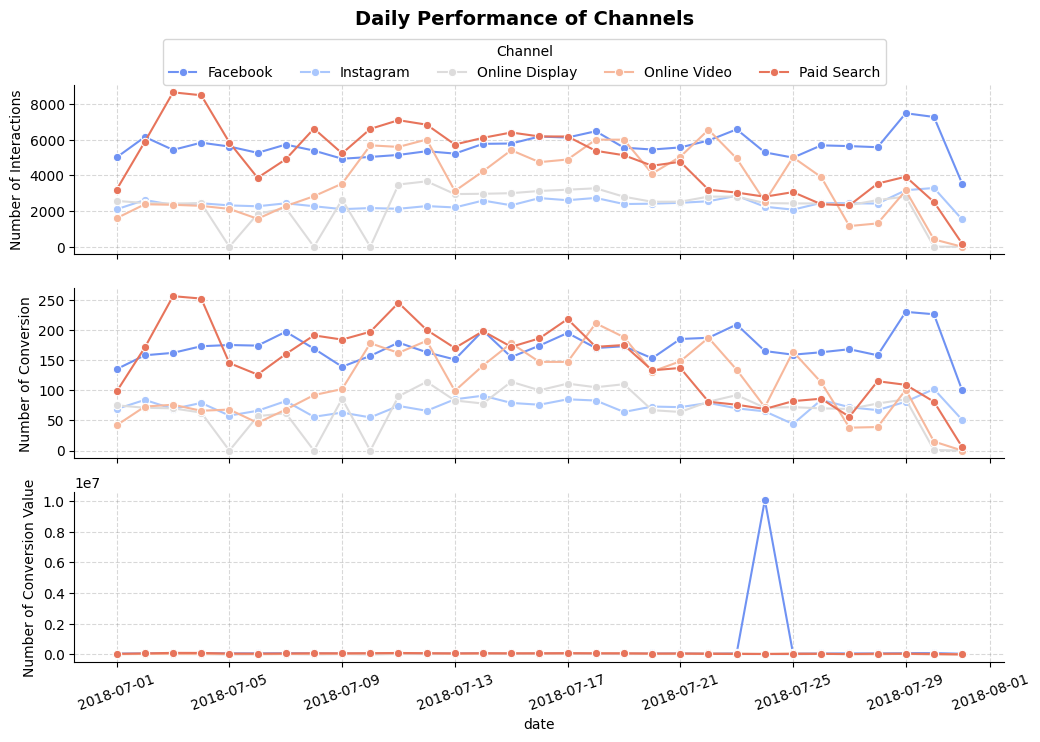

In [19]:
df_plot = (
    df_data
    .assign(date=df_data['timestamp'].dt.date)
    .groupby(['date','channel'],as_index=False)
    .agg(
        interactions=("interaction","count"),
        num_unique_user=("cookie","nunique"),
        conversion=("conversion","sum"),
        conversion_value=("conversion_value","sum"),
    )
)

# Plot the metrics  over time
metrics = ['interactions', 'conversion','conversion_value']

# Create subplots for each metric
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12, len(metrics)*2.5), sharex=True)

# Create a list to collect handles and labels for the combined legend
handles, labels = [], []

# Iterate over each metric and plot it
for i, metric in enumerate(metrics):
    ax = axes[i]
    
    sns.lineplot(
        data=df_plot, 
        x="date", 
        y=metric, 
        hue="channel", 
        palette="coolwarm", 
        marker="o",  # Adding markers at each data point
        ax=ax
    )
    
    ax.set_ylabel(f"Number of {metric.replace('_', ' ').title()}")
    ax.tick_params(axis='x', labelsize=10, rotation=20)

    # add gridlines
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)

    # Collect the handles and labels for the first plot only
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

    # Remove the legend from subplots
    ax.get_legend().remove()

    # Remove spines
    sns.despine(ax=ax)

# Create the combined legend at the top of the plot
fig.legend(handles, labels, title="Channel", loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 0.95))
fig.suptitle("Daily Performance of Channels", fontsize=14, fontweight='bold', y=0.98)

# Show the plot
plt.show()

- For conversion values, there is a significant outlier in the data on 24th July, let's check it 

### Extra checks for extreme conversion values

In [20]:
# Check some metric statistics 
display(
    describe_metrics(
        df=df_data, 
        columns=['conversion_value'], 
        group_by='channel'
    )
)
df_data.sort_values(by=['conversion_value'],ascending=False).head(5)

count   mean       std  min  25%  50%  \
Metric           channel                                                    
conversion_value Facebook        175068.0  68.67  23899.99  0.0  0.0  0.0   
                 Instagram        75096.0  11.40     66.03  0.0  0.0  0.0   
                 Online Display   70883.0  11.44     65.94  0.0  0.0  0.0   
                 Online Video    110879.0  11.78     67.22  0.0  0.0  0.0   
                 Paid Search     150666.0  11.47     66.09  0.0  0.0  0.0   

                                 75%         max  
Metric           channel                          
conversion_value Facebook        0.0  10000000.0  
                 Instagram       0.0       518.5  
                 Online Display  0.0       518.5  
                 Online Video    0.0       518.5  
                 Paid Search     0.0       518.5

,cookie,time,interaction,conversion,conversion_value,channel,timestamp
955,11CFhDAEAFkf1Ah73AD77C1no,2018-07-24T19:56:55Z,conversion,1.0,10000000.0,Facebook,2018-07-24 19:56:55+00:00
360987,Fkk9ECBFE73DChkfnEAnC9FB1,2018-07-28T18:54:44Z,conversion,1.0,518.5,Facebook,2018-07-28 18:54:44+00:00
92984,7F3FD1D3AB7Do1CEnhhf7fink,2018-07-18T14:25:24Z,conversion,1.0,518.5,Paid Search,2018-07-18 14:25:24+00:00
59944,3fDDhknECDkCBhDfCAEEDEhhn,2018-07-03T11:45:24Z,conversion,1.0,518.5,Instagram,2018-07-03 11:45:24+00:00
524547,nB71nEfFfnoiAC19nAnBokDDA,2018-07-17T09:45:20Z,conversion,1.0,518.5,Facebook,2018-07-17 09:45:20+00:00


In [21]:
an_cookie='11CFhDAEAFkf1Ah73AD77C1no'
# Selected user journey
display(df_data.query("cookie in @an_cookie").sort_values(['cookie','timestamp']).set_index(['cookie','timestamp']))

,,time,interaction,conversion,conversion_value,channel
cookie,timestamp,,,,,
11CFhDAEAFkf1Ah73AD77C1no,2018-07-24 19:56:55+00:00,2018-07-24T19:56:55Z,conversion,1.0,10000000.0,Facebook


- A single user with a single record has an extreme value for conversion_value.
- While it should be double-checked with the team, I believe this record is likely incorrect. Therefore, I will retain the conversion but replace the value with NA.

In [22]:
## Replace the extreme conv_value with NA
df_data.loc[df_data['cookie']=='11CFhDAEAFkf1Ah73AD77C1no','conversion_value'] = pd.NA # It replaced with 10000000.0

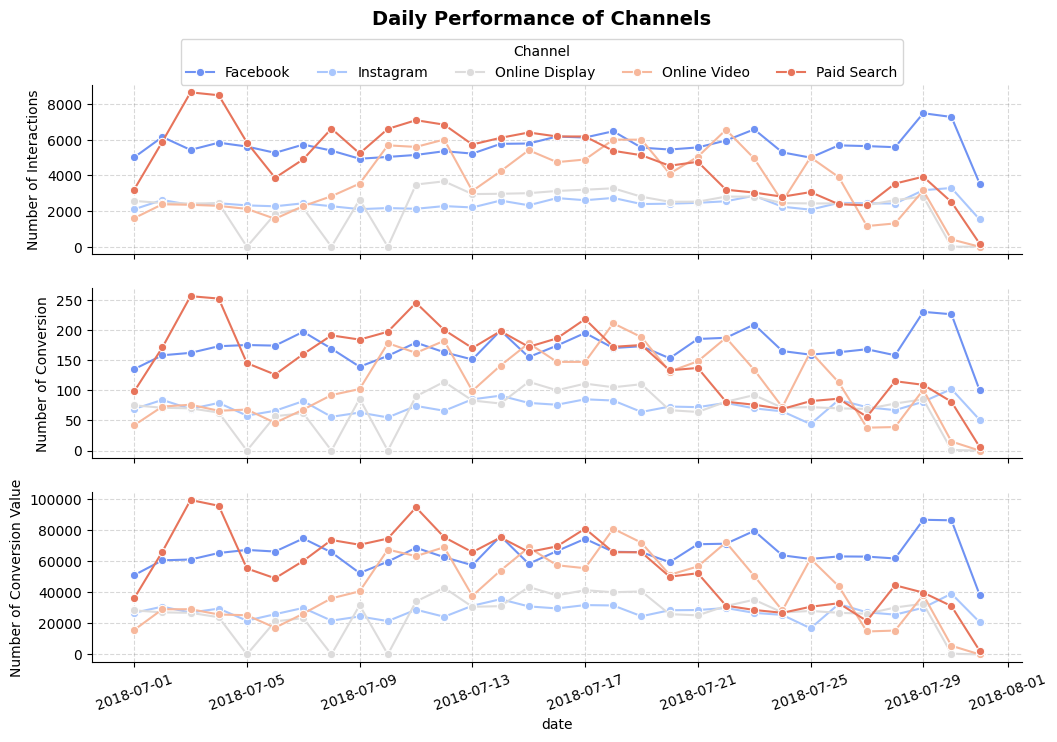

In [23]:
df_plot = (
    df_data
    .assign(date=df_data['timestamp'].dt.date)
    .groupby(['date','channel'],as_index=False)
    .agg(
        interactions=("interaction","count"),
        num_unique_user=("cookie","nunique"),
        conversion=("conversion","sum"),
        conversion_value=("conversion_value","sum"),
    )
)

# Plot the performance over time
metrics = ['interactions', 'conversion','conversion_value']

# Create subplots for each metric
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12, len(metrics)*2.5), sharex=True)

# Create a list to collect handles and labels for the combined legend
handles, labels = [], []

# Iterate over each metric and plot it
for i, metric in enumerate(metrics):
    ax = axes[i]
    
    sns.lineplot(
        data=df_plot, 
        x="date", 
        y=metric, 
        hue="channel", 
        palette="coolwarm", 
        marker="o",  # Adding markers at each data point
        ax=ax
    )
    
    ax.set_ylabel(f"Number of {metric.replace('_', ' ').title()}")
    ax.tick_params(axis='x', labelsize=10, rotation=20)

    # add gridlines
    ax.grid(True, linestyle='--', color='gray', alpha=0.3)

    # Collect the handles and labels for the first plot only
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

    # Remove the legend from subplots
    ax.get_legend().remove()

    # Remove spines
    sns.despine(ax=ax)

# Create the combined legend at the top of the plot
fig.legend(handles, labels, title="Channel", loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 0.95))
fig.suptitle("Daily Performance of Channels", fontsize=14, fontweight='bold', y=0.98)

# Show the plot
plt.show()

- Facebook and Instagram performance remained stable throughout the month.
- Paid Search traffic and conversions saw a significant decline.
- Online Video traffic peaked mid-month.

In [24]:
# Let's see the some key metrics after outlier exclusion
df_channels=(
            df_data
            .groupby(gb_cols)
            .agg(
                interactions=("interaction","count"),
                num_unique_user=("cookie","nunique"),
                conversion=("conversion","sum"),
                conversion_value=("conversion_value","sum"),
            )
            .eval("conv_rate=conversion/interactions*100")
            .eval("avg_conv_val=conversion_value/conversion")
            .eval("conv_channel_share=conversion/conversion.sum()*100")
            .eval("conv_value_channel_share=conversion_value/conversion_value.sum()*100")
            .round(2)
            .sort_values('interactions',ascending=False)
)


columns_and_formats={
    'interactions': "{:,.0f}",  
    'num_unique_user': "{:,.0f}",  
    'conversion': "{:,.0f}",  
    'conversion_value': "€{:,.0f}", 
    'avg_conv_val': "€{:,.1f}",  
    'conv_rate': "{:.2f}%",  
    'conv_channel_share': "{:.1f}%", 
    'conv_value_channel_share': "{:.1f}%",  
}


style_dataframe(df_channels,columns_and_formats,include_cond_formatting=True)

,interactions,num_unique_user,conversion,conversion_value,conv_rate,avg_conv_val,conv_channel_share,conv_value_channel_share
channel,,,,,,,,
Facebook,"175,068","88,125","5,301","€2,021,357",3.03%,€381.3,30.1%,30.1%
Paid Search,"150,666","88,840","4,547","€1,728,222",3.02%,€380.1,25.8%,25.7%
Online Video,"110,879","40,962","3,408","€1,306,498",3.07%,€383.4,19.3%,19.4%
Instagram,"75,096","49,466","2,244","€856,410",2.99%,€381.6,12.7%,12.7%
Online Display,"70,883","42,604","2,139","€811,208",3.02%,€379.2,12.1%,12.1%


In [25]:
df_channel_total=(
    df_data
    .assign(Grand_Total="Total")
    .groupby('Grand_Total')
    .agg(
        interactions=("interaction","count"),
        num_unique_user=("cookie","nunique"),
        conversion=("conversion","sum"),
        conversion_value=("conversion_value","sum"),
    )
    .eval("conv_rate=conversion/interactions*100")
    .eval("avg_conv_val=conversion_value/conversion")
    .eval("conv_channel_share=conversion/conversion.sum()*100")
    .eval("conv_value_channel_share=conversion_value/conversion_value.sum()*100")
    .round(2)
)

style_dataframe(df_channel_total,columns_and_formats,include_cond_formatting=False)

,interactions,num_unique_user,conversion,conversion_value,conv_rate,avg_conv_val,conv_channel_share,conv_value_channel_share
Grand_Total,,,,,,,,
Total,"582,592","240,108","17,639","€6,723,694",3.03%,€381.2,100.0%,100.0%


# Recognise Paths for Attribution Modelling

In [26]:
df_data_featured=(
    df_data
    .sort_values(['cookie','timestamp','interaction'])
    .assign(tot_conv=lambda x: x.groupby(['cookie']).conversion.transform('sum'))
    .assign(tot_conv_value=lambda x: x.groupby(['cookie']).conversion_value.transform('sum'))
    .assign(path_id=lambda x: x.groupby(['cookie', 'tot_conv']).ngroup())
    .assign(num_touch_points=lambda x: x.groupby(['cookie']).channel.transform('count'))
    #.eval("linear_conv=tot_conv/count_touch_point")
    #.eval("linear_conv_val=tot_conv_value/count_touch_point")
    .astype({
        'conversion':'int',
        'tot_conv':'int',
        'num_touch_points':'int',
    })
)

print(f"Shape of Dataframe: {df_data_featured.shape}")
df_data_featured

Shape of Dataframe: (582592, 11)


,cookie,time,interaction,conversion,conversion_value,channel,timestamp,tot_conv,tot_conv_value,path_id,num_touch_points
0,11111FkCnDfDDf1iC97iC713B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram,2018-07-03 13:02:11+00:00,0,0.0,0,4
1,11111FkCnDfDDf1iC97iC713B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display,2018-07-17 19:15:07+00:00,0,0.0,0,4
2,11111FkCnDfDDf1iC97iC713B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display,2018-07-24 15:51:46+00:00,0,0.0,0,4
3,11111FkCnDfDDf1iC97iC713B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display,2018-07-29 07:44:51+00:00,0,0.0,0,4
4,1111nACkD9nFkBBDECD3ki11E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search,2018-07-03 09:44:57+00:00,0,0.0,1,6
...,...,...,...,...,...,...,...,...,...,...,...
586732,ooooEiB1CCoEf9fiiC91Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2018-07-12 23:50:45+00:00,0,0.0,240105,3
586733,ooooEiB1CCoEf9fiiC91Dfhfk,2018-07-12T23:50:54Z,impression,0,0.0,Online Display,2018-07-12 23:50:54+00:00,0,0.0,240105,3
586734,ooooiBh71D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,2018-07-03 12:57:25+00:00,0,0.0,240106,2
586735,ooooiBh71D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2018-07-19 08:17:59+00:00,0,0.0,240106,2


In [27]:
df_paths=(
    df_data_featured
    .groupby(['cookie','path_id','num_touch_points','tot_conv'])
    .agg(
        start=("timestamp","min"),
        end=("timestamp","max"),
        touch_points=("channel",list),
        conversion=("conversion","sum"),
        conversion_value=("conversion_value","sum"),
    )
    .eval("path_days=(end-start).dt.days")
)

#df_paths['path'] = tuple(df_paths['touch_points'].apply(lambda x: ' > '.join(x)))

df_paths

print(f"Shape of Dataframe: {df_paths.shape}")
df_paths

Shape of Dataframe: (240108, 6)


,,,,start,end,touch_points,conversion,conversion_value,path_days
cookie,path_id,num_touch_points,tot_conv,,,,,,
11111FkCnDfDDf1iC97iC713B,0,4,0,2018-07-03 13:02:11+00:00,2018-07-29 07:44:51+00:00,"[Instagram, Online Display, Online Display, On...",0,0.0,25
1111nACkD9nFkBBDECD3ki11E,1,6,0,2018-07-03 09:44:57+00:00,2018-07-11 22:19:53+00:00,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0,8
1113EfE37E93D1BC13iBhBBhF,2,5,0,2018-07-08 10:48:21+00:00,2018-07-12 10:34:38+00:00,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0,3
11173CFE3FoFCn71fBhB3kfon,3,1,0,2018-07-21 10:52:04+00:00,2018-07-21 10:52:04+00:00,[Instagram],0,0.0,0
11179hhBkDF3k3kDkiFi9EFAD,4,1,0,2018-07-10 11:11:24+00:00,2018-07-10 11:11:24+00:00,[Paid Search],0,0.0,0
...,...,...,...,...,...,...,...,...,...
ooooE1hkAFBkED91ChDDiBFAf,240103,1,0,2018-07-03 13:36:19+00:00,2018-07-03 13:36:19+00:00,[Online Display],0,0.0,0
ooooEBE1o1D97ACAAAnDoi3F1,240104,1,0,2018-07-25 20:02:08+00:00,2018-07-25 20:02:08+00:00,[Online Display],0,0.0,0
ooooEiB1CCoEf9fiiC91Dfhfk,240105,3,0,2018-07-06 23:30:38+00:00,2018-07-12 23:50:54+00:00,"[Online Display, Online Display, Online Display]",0,0.0,6


### Quick Analysis the paths

In [28]:
# Check some metric statistics 
describe_metrics(
    df=df_paths, 
    columns=['num_touch_points', 'path_days'], 
    group_by='tot_conv'
)

count  mean   std  min  25%  50%  75%    max
Metric           tot_conv                                                 
num_touch_points 0         222469.0  2.33  2.78  1.0  1.0  1.0  3.0  121.0
                 1          17639.0  3.62  5.32  1.0  1.0  2.0  4.0  134.0
path_days        0         222469.0  3.99  7.10  0.0  0.0  0.0  6.0   30.0
                 1          17639.0  4.52  6.74  0.0  0.0  0.0  8.0   29.0

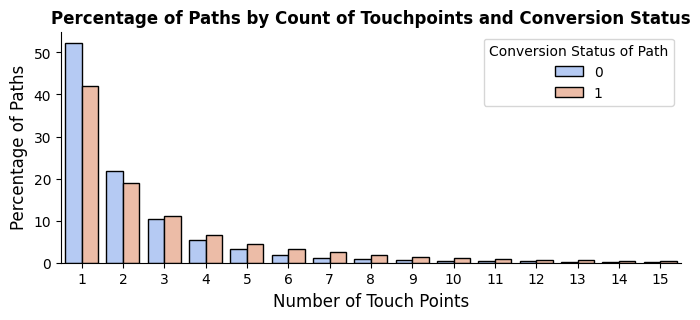

,num_touch_points,tot_conv,num_paths,tot_paths,perc_num_paths
0,1,0,116402,222469,52.3
1,1,1,7417,17639,42.0
2,2,0,48641,222469,21.9
3,2,1,3348,17639,19.0
4,3,0,22871,222469,10.3
5,3,1,1954,17639,11.1


In [29]:
df_plot=(
    df_paths
    .reset_index()
    .groupby(['num_touch_points','tot_conv'],as_index=False)
    .agg(
        num_paths=("path_id","nunique")
    )
    .assign(tot_paths=lambda x: x.groupby(['tot_conv']).num_paths.transform('sum'))
    .eval("perc_num_paths=num_paths/tot_paths*100")
    .round(1)
    .query("num_touch_points <= 15") # to limit the length of path to maximum 15 (to increase readability)
)
plt.figure(figsize=(8, 3))
ax = sns.barplot(
    data=df_plot, 
    x="num_touch_points", 
    y="perc_num_paths", 
    hue="tot_conv", 
    palette="coolwarm", 
    edgecolor="black"
)

plt.title("Percentage of Paths by Count of Touchpoints and Conversion Status", fontsize=12, fontweight='bold')
plt.xlabel("Number of Touch Points", fontsize=12)
plt.ylabel("Percentage of Paths", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Conversion Status of Path")
sns.despine()

plt.show()

# Plot few records to see the actual values.
df_plot.head(6)

- The majority of paths consist of only 1 touchpoint, with 52.3% of paths having no conversion and 42.0% having a conversion.
- Conversion rates tend to increase with the number of touchpoints.
    - Starting from 3 touchpoints, the conversion possibility becomes higher.

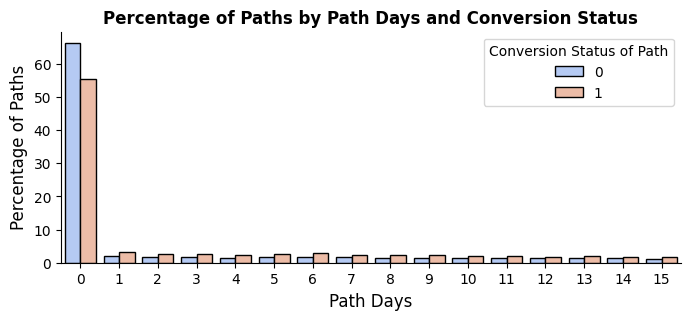

,path_days,tot_conv,num_paths,tot_paths,perc_num_paths
0,0,0,147664,222469,66.4
1,0,1,9747,17639,55.3
2,1,0,4373,222469,2.0
3,1,1,586,17639,3.3
4,2,0,3696,222469,1.7
5,2,1,479,17639,2.7


In [30]:
df_plot=(
    df_paths
    .reset_index()
    .groupby(['path_days','tot_conv'],as_index=False)
    .agg(
        num_paths=("path_id","nunique"),
    )
    .assign(tot_paths=lambda x: x.groupby(['tot_conv']).num_paths.transform('sum'))
    .eval("perc_num_paths=num_paths/tot_paths*100")    
    .query("path_days <= 15") # to limit the length of path to maximum 15 (to increase readability)
    .round(1)
    
)
plt.figure(figsize=(8, 3))
ax = sns.barplot(
    data=df_plot, 
    x="path_days", 
    y="perc_num_paths", 
    hue="tot_conv", 
    palette="coolwarm", 
    edgecolor="black"
)

plt.title("Percentage of Paths by Path Days and Conversion Status", fontsize=12, fontweight='bold')
plt.xlabel("Path Days", fontsize=12)
plt.ylabel("Percentage of Paths", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Conversion Status of Path")
sns.despine()

# Show the plot
plt.show()

# Plot few records to see the actual values.
df_plot.head(6)

- The majority are belong the same day for both category (66% for without conv vs %55 for with conv)
- Conversion rates tend to increase when the number of days in a path increases.
    - Starting from 2 days, the conversion possibility becomes higher.

# Attribution Model

In this assessment, I will evaluate and compare four attribution models: First-Touch, Last-Touch, Linear-Touch, and Markov Chain.

I will be using the 'ChannelAttribution' Python library (https://github.com/DavideAltomare/ChannelAttribution), which I have worked with previously.<br>
This library already supports all four required attribution models, simplifying the task at hand.

    - ChannelAttribution.heuristic_models is used to get 'First-Touch', 'Last-Touch' and  'Linear-Touch'
    - ChannelAttribution.markov_model is used to get 'Markov Chains'

To apply these models, I simply need to create a new dataframe containing the necessary columns for the analysis.

### Get Dataframe (df_path_stats) to work with the model

In [31]:
## Create the required dataframe for the 

# This simply adds the '>' separator between touchpoints in each path, as a string separator is required.
df_paths['path'] = tuple(df_paths['touch_points'].apply(lambda x: '>'.join(x)))

df_path_stats=(
    pd.concat(
        [
            (
                df_paths
                .query("conversion==0")
                .groupby('path')
                .agg(
                    tot_null=("conversion","count"),
                )
            ),
            (
                df_paths
                .query("conversion!=0")
                .groupby('path')
                .agg(
                    tot_conv=("conversion","sum"),
                    tot_conv_value=("conversion_value","sum"),
                )
            ),
        ],
        axis=1
    )
    .eval("conv_rate=tot_conv/(tot_conv+tot_null)*100") # This metric is not needed for the model.
    .fillna(0)
)

df_path_stats.round(2)

,tot_null,tot_conv,tot_conv_value,conv_rate
path,,,,
Facebook,32852.0,2054.0,783880.5,5.88
Facebook>Facebook,7388.0,540.0,201666.0,6.81
Facebook>Facebook>Facebook,2055.0,230.0,88968.5,10.07
Facebook>Facebook>Facebook>Facebook,739.0,84.0,32696.0,10.21
Facebook>Facebook>Facebook>Facebook>Facebook,317.0,40.0,15280.5,11.20
...,...,...,...,...
Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Facebook>Facebook>Facebook>Facebook>Facebook>Paid Search>Paid Search>Paid Search>Facebook>Facebook>Instagram>Paid Search>Paid Search>Paid Search>Facebook>Paid Search>Online Video>Online Video>Paid Search>Facebook>Instagram>Paid Search>Paid Search>Paid Search>Instagram>Facebook>Instagram>Paid Search>Facebook,0.0,1.0,274.5,0.00
Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search,0.0,1.0,366.0,0.00
Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search>Paid Search,0.0,1.0,396.5,0.00


- We have 11.3K unique touch-points combinations and for each path
- We are ready to run the model

## Run heuristic_models to get 'First-Touch', 'Last-Touch' and 'Linear-Touch' results

In [32]:
### heuristic_models function returns results for 'First-Touch', 'Last-Touch' and 'Linear-Touch' at once.
df_heuristic_models=(
    heuristic_models(
        df_path_stats.reset_index(),
        "path",
        "tot_conv",
        var_value="tot_conv_value",
        sep='>', # seperator string of touch-points
        flg_adv=False # To avoid the 'ChannelAttribution Pro' ads note
    )
    .round(2)
)
df_heuristic_models

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,Facebook,5177.0,1968866.5,5301.0,2021357.0,5217.85,1988655.93
1,Instagram,2329.0,889349.5,2244.0,856409.5,2268.01,865571.74
2,Online Display,2160.0,818559.0,2139.0,811208.5,2125.72,806051.67
3,Online Video,3216.0,1233755.5,3408.0,1306498.0,3347.37,1282971.51
4,Paid Search,4757.0,1813164.0,4547.0,1728221.5,4680.05,1780443.66


- For heuristic models, the significance of channels is fairly similar, with only slight variations in their exact values.
- The importance ranking of channels across models is: Facebook, Paid Search, Online Video, Instagram, and Online Display.


## Run markov_model to get 'Markov Chain Model' results

In [33]:
### markov_model function returns results for only 'markov_model'

df_markov_model=(
    markov_model(
        df_path_stats.reset_index(),
        "path",
        "tot_conv",
        var_value="tot_conv_value",
        sep='>', # seperator string of touch-points
        flg_adv=False # To avoid the 'ChannelAttribution Pro' ads note
    )
    .round(2)
)
df_markov_model

Number of simulations: 100000 - Convergence reached: 1.30% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (48) is reached: 99.99%


,channel_name,total_conversions,total_conversion_value
0,Facebook,5291.24,2017650.22
1,Instagram,3496.29,1332326.66
2,Paid Search,3979.28,1512738.72
3,Online Display,2005.05,761821.45
4,Online Video,2867.14,1099157.45


- In the probabilistic data-driven Markov model, Instagram ranks as the third most important channel, following Facebook and Paid Search, in addition to the results from the heuristic models.


## Compare the Results

In [34]:
# Let's combine the results together evaluate the results by comparing each of them

# Prepare the final results dataframe for each channel and attribution model.
df_results_attr_models = (
    pd.concat([
        (
            df_heuristic_models
            [['channel_name', 'first_touch_conversions', 'first_touch_value']]
            .assign(AttributionModel='1-first_touch')
            .set_axis(['channel_name', 'conv','conv_value','AttributionModel'], axis=1)
        ),
        (
            df_heuristic_models
            [['channel_name', 'last_touch_conversions', 'last_touch_value']]
            .assign(AttributionModel='2-last_touch')
            .set_axis(['channel_name', 'conv','conv_value','AttributionModel'], axis=1)
        ),
        (
            df_heuristic_models
            [['channel_name', 'linear_touch_conversions', 'linear_touch_value']]
            .assign(AttributionModel='3-linear_touch')
            .set_axis(['channel_name', 'conv','conv_value','AttributionModel'], axis=1)
        ),
        (
            df_markov_model
            [['channel_name', 'total_conversions', 'total_conversion_value']]
            .assign(AttributionModel='4-markov_model')
            .set_axis(['channel_name', 'conv','conv_value','AttributionModel'], axis=1)
        ),
    ])
    .assign(tot_conv=lambda x: x.groupby(['AttributionModel']).conv.transform('sum'))
    .eval("channel_conv_share=conv/tot_conv*100")
    .assign(tot_conv_value=lambda x: x.groupby(['AttributionModel']).conv_value.transform('sum'))
    .eval("channel_conv_value_share=conv_value/tot_conv_value*100")
    .astype({
        'conv':'int',
        'tot_conv':'int',
    })
    .sort_values(['AttributionModel','channel_name'])
)

df_results_attr_models.round(2)

,channel_name,conv,conv_value,AttributionModel,tot_conv,channel_conv_share,tot_conv_value,channel_conv_value_share
0,Facebook,5177,1968866.50,1-first_touch,17639,29.35,6723694.50,29.28
1,Instagram,2329,889349.50,1-first_touch,17639,13.20,6723694.50,13.23
2,Online Display,2160,818559.00,1-first_touch,17639,12.25,6723694.50,12.17
3,Online Video,3216,1233755.50,1-first_touch,17639,18.23,6723694.50,18.35
4,Paid Search,4757,1813164.00,1-first_touch,17639,26.97,6723694.50,26.97
0,Facebook,5301,2021357.00,2-last_touch,17639,30.05,6723694.50,30.06
1,Instagram,2244,856409.50,2-last_touch,17639,12.72,6723694.50,12.74
2,Online Display,2139,811208.50,2-last_touch,17639,12.13,6723694.50,12.06
3,Online Video,3408,1306498.00,2-last_touch,17639,19.32,6723694.50,19.43
4,Paid Search,4547,1728221.50,2-last_touch,17639,25.78,6723694.50,25.70


### Compare Results by Plotting - Absolute Values

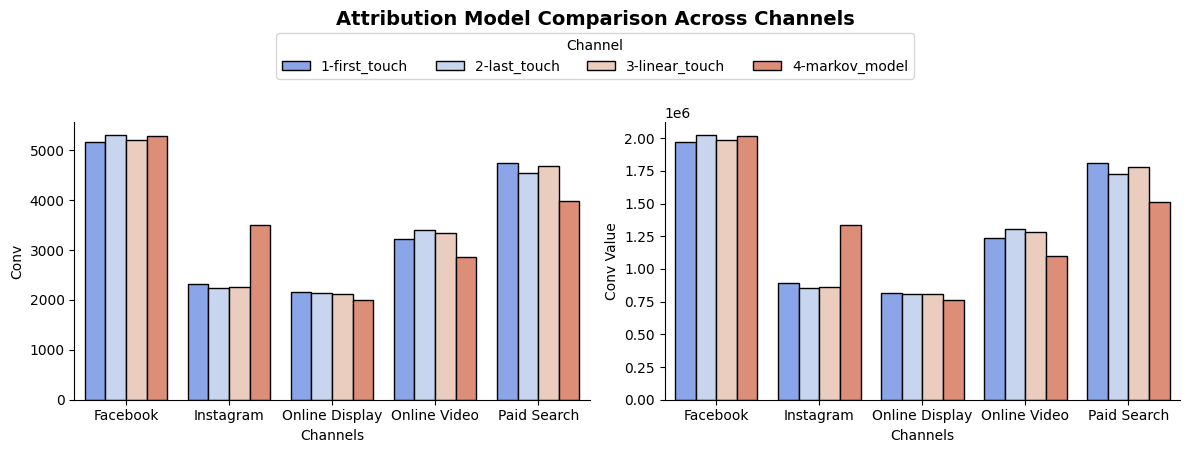

In [35]:
metrics = ['conv', 'conv_value']
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(len(metrics)*6, 4))  # 1 row, 2 columns

# Create a list to collect handles and labels for the combined legend
handles, labels = [], []

for i, (ax, metric) in enumerate(zip(axes, metrics)):
    sns.barplot(
        data=df_results_attr_models, 
        x="channel_name", 
        y=metric, 
        hue="AttributionModel", 
        palette="coolwarm", 
        edgecolor="black", 
        ax=ax
    )
    
    # Set the title and labels for the y-axis
    ax.set_ylabel(f"{metric.replace('_', ' ').title()}")
    ax.set_xlabel(f"Channels")
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    # Collect the handles and labels for the first plot only
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

    # Remove the legend from subplots
    ax.get_legend().remove()

    sns.despine(ax=ax)

# Create the combined legend at the top of the plot
fig.legend(handles, labels, title="Channel", loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.08))
fig.suptitle("Attribution Model Comparison Across Channels", fontsize=14, fontweight='bold', y=1.12)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Show the values in a pivot table at the bottom
for metric in metrics:
    df_piv=(
        pd.pivot_table(
            df_results_attr_models.assign(Metric=metric),
            values=metric,
            index=['Metric','AttributionModel'],
            columns='channel_name',
            aggfunc = 'sum',
        )
    )
    df_piv['Total'] = df_piv.sum(axis=1)
    # Show the values with formatted by using style_dataframe defined in the beginning
    if metric == 'conv':
        display(style_dataframe(df_piv, {column: "{:,.0f}" for column in df_piv.columns}, include_cond_formatting=False))
    if metric == 'conv_value':
        display(style_dataframe(df_piv, {column: "€{:,.0f}" for column in df_piv.columns}, include_cond_formatting=False))

- The results are quite parallel in both metrics.
- Facebook remains the largest contributor, maintaining consistent values across all models.
- Instagram gains significant importance in the Markov Chain model, rising to become the third most important channel.
- Paid Search and Online Video experience the greatest performance decline.
- Online Display has the least impact.
- The Markov Chain model highlights the significance of data-driven attribution models.

### Compare Results by Plotting - Share Percentage

Just to see the share of the importances for both metrics

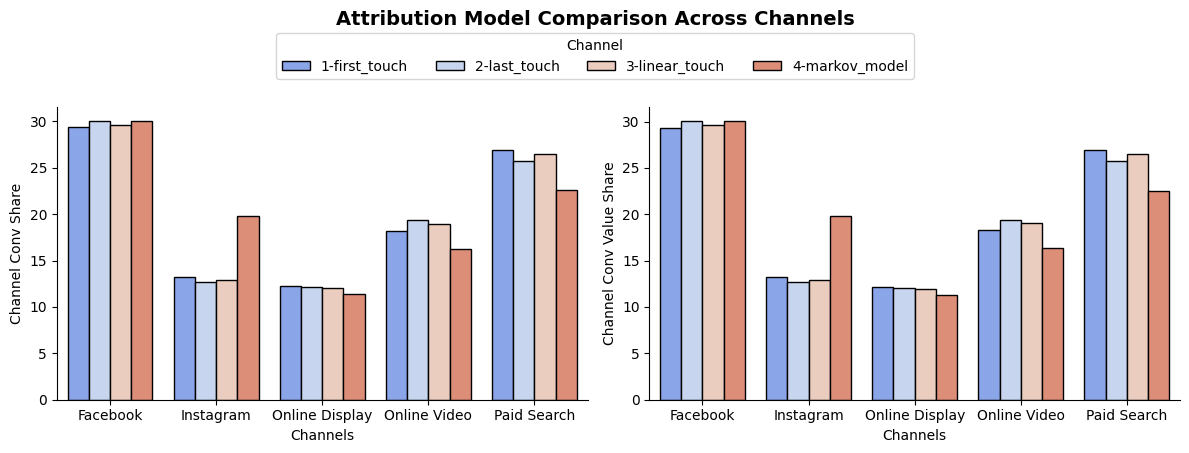

In [36]:
metrics = ['channel_conv_share', 'channel_conv_value_share']
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(len(metrics)*6, 4))  # 1 row, 2 columns

# Create a list to collect handles and labels for the combined legend
handles, labels = [], []

for i, (ax, metric) in enumerate(zip(axes, metrics)):
    sns.barplot(
        data=df_results_attr_models, 
        x="channel_name", 
        y=metric, 
        hue="AttributionModel", 
        palette="coolwarm", 
        edgecolor="black", 
        ax=ax
    )
    
    # Set the title and labels for the y-axis
    ax.set_ylabel(f"{metric.replace('_', ' ').title()}")
    ax.set_xlabel(f"Channels")
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    # Collect the handles and labels for the first plot only
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

    # Remove the legend from subplots
    ax.get_legend().remove()

    sns.despine(ax=ax)

# Create the combined legend at the top of the plot
fig.legend(handles, labels, title="Channel", loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.08))
fig.suptitle("Attribution Model Comparison Across Channels", fontsize=14, fontweight='bold', y=1.12)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Show the values in a pivot table at the bottom
for metric in metrics:
    df_piv=(
        pd.pivot_table(
            df_results_attr_models.assign(Metric=metric),
            values=metric,
            index=['Metric','AttributionModel'],
            columns='channel_name',
            aggfunc = 'sum',
        )
    )
    df_piv['Total'] = df_piv.sum(axis=1)
    # Show the values with formatted by using style_dataframe defined in the beginning
    display(style_dataframe(df_piv, {column: "{:.1f}%" for column in df_piv.columns}, include_cond_formatting=False))